# Deutsch-Jozsa algorithm application

The following is an application on QISKIT of Deusch-Josza algorithm to determine the nature of an hidden boolean function. The function could be either constant, i.e. input independent, or balanced, so input dependent, and based on the elements of the starting domain wikl assume a balanced number of outputs.

The exercise is based on the following steps:

1) code import

2) circuit initialization

3) random generation of the "function"

4) superposition of the entire system

5) oracle realization based on the type of the function

7) run on simulator

8) print & plot of the results

## A (qu)bit of theory and algorithm development

This algorithm is interesting because it was in the history of quantum information the first one to show a sort of improvement, advantage, in the quantum approach compared to the classical one.
With the quantum approach, it is possible to achieve the desired response with only one execution of the code, as long as we have a sufficient number of qubits at disposal to manage the input data. On the other hand i the classical approach in general it is necessary to perform at least 2 runs i the best case scenario, while on average it is necesary to sample half of the inputs (plus one, for example with 8 inputs in general we need 5 attempts).

So for a classical computer the number of attempts is  

$$
2^{n-1} + 1 
$$
Algorithm steps
1. Prepare 2 quantum registers ala initialized at |0>. The first is a register of $n$-qubits (in this case 2) to interrogate the oracle, the second one is a register composed of 1 qubit to store the oracle's answer
$$
|0\ldots 0\rangle |0\rangle
$$
2. Aply superposition on all qubits of the first register with the Hadamard gate.
$$
H^{\otimes^n} |0\ldots 0\rangle |0\rangle = \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |0\rangle 
$$
3. Let's flip the second register (apply gate $X$) and let's apply the Hadamard gate. In this way we can register the response of the oracle in the phase.
$$
\frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |0\rangle \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle ( |0\rangle - |1\rangle )
$$
4. Interrogate the oracle
$$
\frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle ( |0\rangle - |1\rangle ) \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}(-1)^{f(i)}|i\rangle ( |0\rangle - |1\rangle ) 
$$
5. Apply again $H$ to the first register

6. Measure the first register. If even one of the qubits it is non-zero, then the hidden function is balanced, otherwise is constant. 

The explanation of the result can be explained in this way:: 

When the boolean function is constant, the quantum state before and after the application of the oracle is the same. The inverse of the Hadamard gate is the Hadamard gate itself. In this way in the step 5 we are only  reverting the step 2 to get back the same initial state of all |0> in the first register.

On the other hand when the hidden function is balanced, the quantum state after the oracle is orthogonal to the initial one. So with step 5 when the operation is reverted, we get probability equal to zero to get back a state with all zeros in the first register.

## Code Import <a id="circuit"></a>

Load in the python environment the required qiskit modules

In [3]:
# useful additional packages 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import qiskit as qk
#from qiskit.wrapper.jupyter import *

# import basic plot tools
from qiskit.tools.visualization import circuit_drawer, plot_histogram

## Load IBM-Q <a id="circuit"></a>

If the account was already loaded we will only get a warning

In [4]:
#IBMQ.save_account('APItoken')
# Load our saved IBMQ accounts
IBMQ.load_accounts()

Create first quantum register (2 qubits)

In [5]:
n = 2 # n is the length of the first register

let's code the algorithm with the structure described before

In [6]:
# Let's choose ranomly the type of oracle. The probability that it is balanced is 50% and that is constant is 50%
# In order to do so we will use a function from numpy module

oracleType, oracleValue = np.random.randint(2), np.random.randint(2)

if oracleType == 0:
    print("The oracle is constant ", oracleValue)
else:
    print("The oracle is balanced")
    a = np.random.randint(1,2**n) # let's save an hidden value for the balanced function. 

# create quantum and classical registers all initialized at zero
# 2 qubits for oracle interrogation, and the other one is to save the result
qr = QuantumRegister(n+1) 
# we only need the classical register for the measurement of the first quantum circuit
cr = ClassicalRegister(n)

circuitName = "DeutschJozsa"
djCircuit = QuantumCircuit(qr, cr)

# Superpose the first register.
for i in range(n):
    djCircuit.h(qr[i])

# Invert the second register and apply H.
djCircuit.x(qr[n])
djCircuit.h(qr[n])
    
# Let's visualize a barrier of the oracle (this is only for stylistical purpose)
djCircuit.barrier()

if oracleType == 0:#The function is constant 
    if oracleValue == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.iden(qr[n])
else: # The function is balanced, in that case the oracle applies a CNOT on the qubit i controlling the qubit n
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
        
# End of the oracle, let's close the barrier
djCircuit.barrier()

# Apply H to each qubit
for i in range(n):
    djCircuit.h(qr[i])
    
# Measure
djCircuit.barrier()
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

The oracle is balanced


## Run on simulator

Visualize the circuit.

/srv/conda/lib/python3.6/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)
WARNING Unable to compile latex. The output from the pdflatex command can be found in latex_error.log


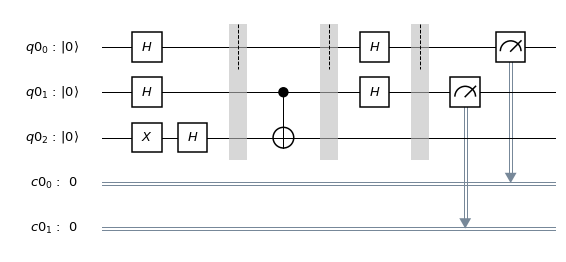

In [7]:
#draw the circuit
circuit_drawer(djCircuit)

Execute the circuit on the simulator

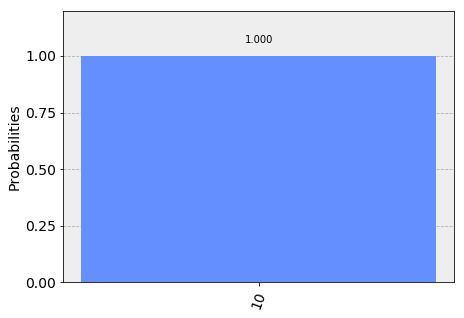

In [9]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
job = qk.execute(djCircuit, backend=backend, shots=shots)
results = job.result() 
answer = results.get_counts()

plot_histogram(answer)

Repeat the experiment changing the number of qubits showing the different behavior based on the hidden function 

## Run on real device

The Deutsch-Jozsa algorithm has a theoretical valence.n Given the fact that the real device is noisy, the result is probabilistic. If we use a probabilistic approach also for the classical computer, then the problem is in the same domain BPP (Bounded error Probabilistic Polynomial Time) and the number of iteractions to solve it becomes constant and the two proposed methods will reach asymptotically the same efficiency.

In [11]:
from qiskit.tools.monitor import job_monitor
backend = IBMQ.get_backend('ibmq_16_melbourne')
shots = 1024 
job = qk.execute(djCircuit, backend=backend, shots=shots)
job_monitor(job, interval=5)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

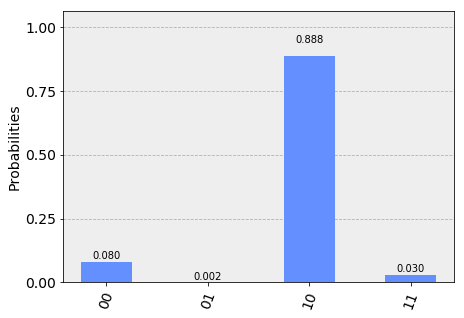

In [17]:
results = job.result()
answer = results.get_counts()

threshold = int(0.03 * shots) # set a threshold for significant measurements
filteredAnswer = {k: v for k,v in answer.items() if v >= threshold} # filter for an optimal visualization of the results

removedCounts = np.sum([ v for k,v in answer.items() if v < threshold ]) # 
filteredAnswer['other_bitstring'] = removedCounts  # 

plot_histogram(answer)

In [18]:
print(answer)

{'10': 909, '01': 2, '00': 82, '11': 31}
